In [1]:
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

from qmlab.qsvm import QSVC
from qmlab.preprocessing import parse_biomed_data_to_ndarray, reduce_feature_dim
from qmlab.plots.plot_model import plot_decision_boundaries

random_state = 12345

In [2]:
X, y = parse_biomed_data_to_ndarray("haberman_new")
X = reduce_feature_dim(X, num_features=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(244, 2)
(62, 2)
(244,)
(62,)


In [3]:
from qiskit.circuit.library import PauliFeatureMap

num_features = X_train.shape[1]
num_layers = 1

qfm = PauliFeatureMap(feature_dimension=num_features, reps=num_layers, alpha=2.0, paulis=["Z"])
print(qfm.decompose().draw(plot_barriers=None, fold=150, style="textbook"))

     ┌───┐┌─────────────┐
q_0: ┤ H ├┤ P(2.0*x[0]) ├
     ├───┤├─────────────┤
q_1: ┤ H ├┤ P(2.0*x[1]) ├
     └───┘└─────────────┘


In [4]:
from qmlab.qfm import QuantumFeatureMap

num_features = X_train.shape[1]
num_qubits = num_features
num_layers = 1

qfm = QuantumFeatureMap(feature_dimension=num_features, num_qubits=num_qubits, reps=num_layers, 
                        alpha=2.0, gates=["H", "RZ"], entanglement="linear")
print(qfm.draw(plot_barriers=False, fold=150, style="textbook"))

     ┌───┐ ┌──────────────┐ 
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├─
     ├───┤ ├──────────────┤ 
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─
     └───┘ └──────────────┘ 


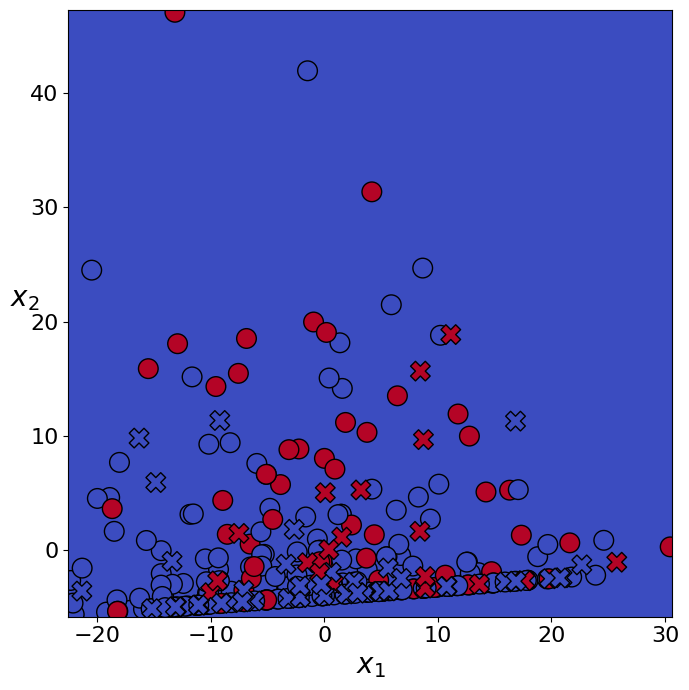

In [5]:
clf = QSVC(
    C=1.0,
    feature_map=["H", "RZ", "CZ"],
    reps=1,
    num_qubits=2,
    entanglement="linear",
    random_state=random_state,
)

clf.fit(X_train, y_train)
plot_decision_boundaries(clf, X_train, y_train, X_test, y_test)